In [1]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, Activation
from tensorflow.keras.layers import Dense, Dropout, Flatten, MaxPool2D
from tensorflow.keras.models import Sequential
from keras.applications.vgg16 import VGG16 as PTM, preprocess_input
from tensorflow.keras import backend as bk
import numpy as np
from tensorflow import keras
import glob
import os
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
train_path = '/content/drive/MyDrive/GreatLearning/Hackthon/HDFCLife/train'
test_path = '/content/drive/MyDrive/GreatLearning/Hackthon/HDFCLife/test'
gt_path = '/content/drive/MyDrive/GreatLearning/Hackthon/HDFCLife/GroundTruth/Gt.csv'

In [3]:
target_size= (128,128)
batch_size = 5
epochs = 10 * 10

In [35]:
test_dataset = []
file_ids = []
testData =  glob.glob('{}/*.jpg'.format(test_path))
for data in testData:
  img = tf.keras.preprocessing.image
  image = img.load_img(data, color_mode='rgb', target_size= target_size)
  image = np.array(image)
  file_id = os.path.basename(data).replace('.jpg', '')
  test_dataset.append(image)
  file_ids.append(int(file_id))

In [5]:
file_ids[10]

10

In [6]:
imageDataGen = ImageDataGenerator(rescale= 1./ 255,
                                 shear_range= 0.2,
                                 zoom_range=0.2, 
                                 horizontal_flip=True, 
                                 validation_split=0.2,
                                 width_shift_range=0.2,
                                 height_shift_range=0.2,
                                 fill_mode="nearest",
                                  preprocessing_function=preprocess_input)



train_generator = imageDataGen.flow_from_directory(
    train_path,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training') # set as training data

validation_generator = imageDataGen.flow_from_directory(
    train_path, # same directory as training data
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation') # set as validation data


Found 473 images belonging to 2 classes.
Found 118 images belonging to 2 classes.


In [7]:
train_generator.class_indices

{'Mask': 0, 'NoMask': 1}

In [8]:
pd.DataFrame(train_generator.classes, columns=['Classes']).value_counts()

Classes
0          384
1           89
dtype: int64

In [9]:
pd.DataFrame(validation_generator.classes, columns=['Classes']).value_counts()

Classes
0          96
1          22
dtype: int64

In [10]:
ptm = PTM(input_shape=tuple(list(target_size)+[3]),
            weights='imagenet', 
            include_top=False)
ptm.trainable = False 

In [11]:
ptm.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0     

In [12]:
model = Sequential()
model.add(ptm)
model.add(Flatten())
model.add(Dense(1024,activation='relu'))
model.add(Dense(512,activation='relu')) 
model.add(Dense(256,activation='relu')) 
model.add(Dropout(.3))
model.add(Dense(128,activation='relu'))
model.add(Dropout(.2))
model.add(Dense(2,activation='softmax'))

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              8389632   
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               3

In [14]:
model.compile(optimizer='adam', 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [15]:
with tf.device('/device:GPU:0'):
  training_history = model.fit(train_generator,steps_per_epoch=len(train_generator) ,epochs=epochs, validation_data=validation_generator, validation_steps=len(validation_generator), verbose=1)

Epoch 1/100
95/95 [==============================] - 9s 66ms/step - loss: 0.9750 - accuracy: 0.7698 - val_loss: 0.4421 - val_accuracy: 0.8136
Epoch 2/100
95/95 [==============================] - 6s 60ms/step - loss: 0.4081 - accuracy: 0.7983 - val_loss: 0.4528 - val_accuracy: 0.7797
Epoch 3/100
95/95 [==============================] - 6s 61ms/step - loss: 0.3688 - accuracy: 0.8589 - val_loss: 0.4473 - val_accuracy: 0.8220
Epoch 4/100
95/95 [==============================] - 6s 60ms/step - loss: 0.3837 - accuracy: 0.8532 - val_loss: 0.3912 - val_accuracy: 0.8136
Epoch 5/100
95/95 [==============================] - 6s 61ms/step - loss: 0.3492 - accuracy: 0.8805 - val_loss: 0.3612 - val_accuracy: 0.8475
Epoch 6/100
95/95 [==============================] - 6s 59ms/step - loss: 0.3016 - accuracy: 0.8541 - val_loss: 0.3697 - val_accuracy: 0.8559
Epoch 7/100
95/95 [==============================] - 6s 59ms/step - loss: 0.3152 - accuracy: 0.8729 - val_loss: 0.3391 - val_accuracy: 0.8559
Epoch 

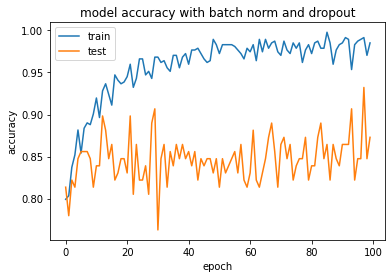

In [16]:
# summarize history for accuracy
plt.plot(training_history.history['accuracy'])
plt.plot(training_history.history['val_accuracy'])
plt.title('model accuracy with batch norm and dropout')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

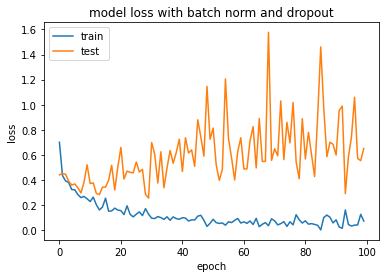

In [17]:
# summarize history for loss
plt.plot(training_history.history['loss'])
plt.plot(training_history.history['val_loss'])
plt.title('model loss with batch norm and dropout')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [40]:
val_dataset_lables = validation_generator.labels
val_dataset_lables

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [30]:
classes = train_generator.class_indices
classes = classes.keys()
classes = list(classes)
classes

['Mask', 'NoMask']

In [36]:
file_ids

[41,
 39,
 27,
 35,
 45,
 38,
 32,
 31,
 29,
 9,
 1,
 26,
 24,
 21,
 28,
 7,
 42,
 44,
 25,
 12,
 6,
 43,
 0,
 10,
 19,
 4,
 3,
 18,
 15,
 37,
 14,
 16,
 23,
 2,
 11,
 17,
 30,
 20,
 40,
 13,
 22,
 33,
 34,
 8,
 36,
 5]

In [41]:
pred_test_result = []
for file_id, img in zip(file_ids, test_dataset):
  exp_img = np.expand_dims(img, axis=0)
  val_dataset_pred = model.predict(exp_img)
  pred_val = np.argmax(val_dataset_pred)
  pred_val_lable = classes[pred_val]
  val_dataset_pred_lable = None
  if pred_val_lable == 'Mask':
    val_dataset_pred_lable = 1
  else:
    val_dataset_pred_lable = 0
  result = [file_id,  val_dataset_pred_lable, pred_val_lable]
  #print(val_dataset_pred)
  print(result)
  pred_test_result.append(result)
  print("\n")

[41, 1, 'Mask']


[39, 1, 'Mask']


[27, 0, 'NoMask']


[35, 0, 'NoMask']


[45, 1, 'Mask']


[38, 1, 'Mask']


[32, 1, 'Mask']


[31, 1, 'Mask']


[29, 1, 'Mask']


[9, 1, 'Mask']


[1, 1, 'Mask']


[26, 1, 'Mask']


[24, 1, 'Mask']


[21, 1, 'Mask']


[28, 1, 'Mask']


[7, 1, 'Mask']


[42, 1, 'Mask']


[44, 1, 'Mask']


[25, 1, 'Mask']


[12, 1, 'Mask']


[6, 1, 'Mask']


[43, 0, 'NoMask']


[0, 1, 'Mask']


[10, 1, 'Mask']


[19, 1, 'Mask']


[4, 1, 'Mask']


[3, 1, 'Mask']


[18, 1, 'Mask']


[15, 1, 'Mask']


[37, 0, 'NoMask']


[14, 1, 'Mask']


[16, 1, 'Mask']


[23, 1, 'Mask']


[2, 1, 'Mask']


[11, 1, 'Mask']


[17, 1, 'Mask']


[30, 1, 'Mask']


[20, 1, 'Mask']


[40, 1, 'Mask']


[13, 1, 'Mask']


[22, 1, 'Mask']


[33, 1, 'Mask']


[34, 0, 'NoMask']


[8, 1, 'Mask']


[36, 0, 'NoMask']


[5, 1, 'Mask']




In [44]:
pred_test_result_df = pd.DataFrame(pred_test_result, columns=['file_id', 'label', 'label_value'])
pred_test_result_df.sort_values(by='file_id')

,file_id,label,label_value
22,0,1,Mask
10,1,1,Mask
33,2,1,Mask
26,3,1,Mask
25,4,1,Mask
45,5,1,Mask
20,6,1,Mask
15,7,1,Mask
43,8,1,Mask
9,9,1,Mask


In [68]:
subbmit =pred_test_result_df.drop(['label_value'], axis=1)
subbmit.to_csv('HDFC_Hackthon_Submit_1.csv', index=False)